# Assignment 1: Austin Animal Shelter Outcomes

**Module:** COMP47490 Machine Learning, Autumn 2021  
**Student:** Rajit Banerjee, 18202817  
**Data:** `../data/animal_shelter_18202817.csv` (source of sample: [data.austintexas.gov](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238))

Import all required packages.

In [1]:
from typing import List, Union, Tuple
from pprint import pprint
from collections import defaultdict, Counter
from collections import Counter
import time
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **scikit-learn: version 1.0.1**
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate 
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB   
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# **mlxtend: version 0.19.0**
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

%matplotlib inline

## 1A: Data Cleaning

The first step in any machine learning task is to perform exploratory data analysis and data cleaning.

In [2]:
df = pd.read_csv("../data/animal_shelter_18202817.csv")
df_raw = df.copy()
df

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Outcome
0,A819419,*Chicken,09/22/2020 10:33:00 AM,09/22/2020 10:33:00 AM,04/28/2020,Cat,Spayed Female,4 months,Domestic Shorthair,Blue Tabby/White,0
1,A710946,*Sabrina,09/07/2015 12:28:00 PM,09/07/2015 12:28:00 PM,06/15/2015,Cat,Spayed Female,2 months,Domestic Shorthair Mix,Torbie,0
2,A572792,Oreo,05/23/2014 05:16:00 PM,05/23/2014 05:16:00 PM,05/06/2007,Dog,Neutered Male,7 years,English Springer Spaniel Mix,Black/White,0
3,A807189,Sequoia,10/27/2019 04:44:00 PM,10/27/2019 04:44:00 PM,08/12/2019,Dog,Spayed Female,2 months,Labrador Retriever/Redbone Hound,Red/Black,0
4,A746717,NaN,04/08/2017 09:00:00 AM,04/08/2017 09:00:00 AM,04/07/2016,Cat,Intact Male,1 year,Domestic Shorthair Mix,White/Orange,0
...,...,...,...,...,...,...,...,...,...,...,...
4995,A803667,Jack,09/04/2019 07:04:00 PM,09/04/2019 07:04:00 PM,09/04/2017,Cat,Neutered Male,2 years,Domestic Shorthair,Orange Tabby,0
4996,A834769,NaN,05/20/2021 02:29:00 PM,05/20/2021 02:29:00 PM,04/18/2021,Cat,Intact Male,4 weeks,Domestic Shorthair,Lynx Point,0
4997,A826518,NaN,12/04/2020 11:06:00 AM,12/04/2020 11:06:00 AM,11/30/2014,Dog,Spayed Female,6 years,Miniature Poodle,Brown/Gray,0
4998,A748803,NaN,05/11/2017 05:02:00 PM,05/11/2017 05:02:00 PM,02/20/2017,Dog,Neutered Male,2 months,Labrador Retriever Mix,Black/White,0


The raw dataset has 5000 observations with 11 characteristics.

Key points to be noted from the data description:
    
- The animal shelter in question is concerned with reducing the risk of animal death.
- A data analytics solution for death risk prediction will help them in their planning 
  towards improving the welfare of shltered animals.
- Outcome = 1 implies a *negative* outcome, e.g. death.
- Outcome = 0 implies a *positive* outcome, e.g. adoption, return to owner.

### 1. Convert features to appropriate data types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Animal ID         5000 non-null   object
 1   Name              3507 non-null   object
 2   DateTime          5000 non-null   object
 3   MonthYear         5000 non-null   object
 4   Date of Birth     5000 non-null   object
 5   Animal Type       5000 non-null   object
 6   Sex upon Outcome  4999 non-null   object
 7   Age upon Outcome  5000 non-null   object
 8   Breed             5000 non-null   object
 9   Color             5000 non-null   object
 10  Outcome           5000 non-null   int64 
dtypes: int64(1), object(10)
memory usage: 429.8+ KB


On examining the data description, we can make the following changes:
- `DateTime`, `MonthYear`: `object` to `datetime64`, since both the date and time are provided.
- `Date of Birth`: `object` to `period[D]`, i.e. period with frequency = day, since the time of birth is not provided (also insignificant).
- `Animal Type`, `Sex upon Outcome`, `Age upon Outcome`, `Breed`, `Color`: `object` to `category`, since there are a finite set of text values for these features.
- `Outcome`: `uint8`, since it is a single bit of information.

In [4]:
def change_types(df: pd.DataFrame, changes: dict) -> None:
    for new_type, columns in changes.items():
        for col in columns:
            df[col] = df[col].astype(new_type)


change_types(df, changes={
    "datetime64": ["DateTime", "MonthYear"],
    "period[D]": ["Date of Birth"],
    "category": ["Animal Type", "Sex upon Outcome", "Age upon Outcome", "Breed", "Color"],
    "uint8": ["Outcome"]
})
df.dtypes

Animal ID                   object
Name                        object
DateTime            datetime64[ns]
MonthYear           datetime64[ns]
Date of Birth            period[D]
Animal Type               category
Sex upon Outcome          category
Age upon Outcome          category
Breed                     category
Color                     category
Outcome                      uint8
dtype: object

### 2. Check for duplicates

In [5]:
# Check rows
df[df.duplicated(keep=False)]

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Outcome


In [6]:
# Check columns
dfT = df.T  # transpose dataframe and perform same check as done for rows
dfT[dfT.duplicated(keep=False)]

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
DateTime,2020-09-22 10:33:00,2015-09-07 12:28:00,2014-05-23 17:16:00,2019-10-27 16:44:00,2017-04-08 09:00:00,2016-03-27 09:02:00,2013-10-07 17:06:00,2014-12-12 16:13:00,2019-06-13 12:36:00,2016-11-10 11:02:00,...,2014-01-10 14:20:00,2014-12-03 18:28:00,2017-11-28 15:50:00,2019-01-18 11:02:00,2014-06-06 12:28:00,2019-09-04 19:04:00,2021-05-20 14:29:00,2020-12-04 11:06:00,2017-05-11 17:02:00,2015-04-24 07:59:00
MonthYear,2020-09-22 10:33:00,2015-09-07 12:28:00,2014-05-23 17:16:00,2019-10-27 16:44:00,2017-04-08 09:00:00,2016-03-27 09:02:00,2013-10-07 17:06:00,2014-12-12 16:13:00,2019-06-13 12:36:00,2016-11-10 11:02:00,...,2014-01-10 14:20:00,2014-12-03 18:28:00,2017-11-28 15:50:00,2019-01-18 11:02:00,2014-06-06 12:28:00,2019-09-04 19:04:00,2021-05-20 14:29:00,2020-12-04 11:06:00,2017-05-11 17:02:00,2015-04-24 07:59:00


It appears that there are no duplicate rows, but the `DateTime` and `MonthYear` columns are identical, so we can safely drop the latter.

In [7]:
df.drop(columns=["MonthYear"], inplace=True)
print(f"Duplicate rows remaining: {len(df[df.duplicated(keep=False)])}")
print(f"Duplicate columns remaining: {len(df.T[df.T.duplicated(keep=False)])}")

Duplicate rows remaining: 0
Duplicate columns remaining: 0


### 3. Check for constant columns

In [8]:
df.select_dtypes(["category"]).describe().T

,count,unique,top,freq
Animal Type,5000,5,Dog,2884
Sex upon Outcome,4999,5,Neutered Male,1809
Age upon Outcome,5000,44,1 year,869
Breed,5000,561,Domestic Shorthair Mix,1199
Color,5000,224,Black/White,544


In [9]:
df.nunique()

Animal ID           4968
Name                2417
DateTime            4948
Date of Birth       2944
Animal Type            5
Sex upon Outcome       5
Age upon Outcome      44
Breed                561
Color                224
Outcome                2
dtype: int64

All columns have cardinality > 1, hence there are no constant columns in the dataset. The issue of unnecessarily high cardinality of `Breed` and `Color` features will be dealt with when fixing data quality issues.

Save the intermediate cleaned dataset.

In [10]:
df.to_csv("../data/animal_shelter_cleaned_1ai.csv")

### 4. Check for outliers and typographical/data input errors

In [11]:
df.columns

Index(['Animal ID', 'Name', 'DateTime', 'Date of Birth', 'Animal Type',
       'Sex upon Outcome', 'Age upon Outcome', 'Breed', 'Color', 'Outcome'],
      dtype='object')

Since there aren't any numerical predictor features, there is no need to check for numerical outliers.

We can count the unique values in some of our features:

In [12]:
for col in ["Animal Type", "Sex upon Outcome", "Age upon Outcome", "Breed", "Color", "Outcome"]:
    print(f"{'-' * 38}\n{df[col].value_counts(dropna=False)}")

--------------------------------------
Dog          2884
Cat          1878
Other         223
Bird           14
Livestock       1
Name: Animal Type, dtype: int64
--------------------------------------
Neutered Male    1809
Spayed Female    1554
Intact Female     650
Intact Male       630
Unknown           356
NaN                 1
Name: Sex upon Outcome, dtype: int64
--------------------------------------
1 year       869
2 years      787
2 months     629
3 years      296
3 months     227
1 month      185
4 years      176
4 months     174
5 years      153
5 months     138
6 months     109
6 years      105
7 years      101
8 years       94
8 months      90
2 weeks       88
3 weeks       75
10 months     73
4 weeks       68
10 years      63
9 months      56
7 months      52
9 years       50
11 months     42
12 years      39
1 weeks       38
11 years      37
1 week        28
2 days        21
13 years      21
3 days        20
6 days        15
15 years      14
14 years      12
1 day         

Among other things, observations that stand out above are: `Age upon Outcome` as `-1 years` and `0 years`.

In [13]:
df[df["Age upon Outcome"].isin(["-1 years", "0 years"])]

,Animal ID,Name,DateTime,Date of Birth,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Outcome
2452,A687107,Montopolis,2018-02-28 11:18:00,2019-03-17,Dog,Neutered Male,-1 years,Rhod Ridgeback,Red/Brown,0
2491,A797495,Ace,2019-06-15 12:44:00,2020-12-16,Dog,Neutered Male,-1 years,Cairn Terrier,Black/Tan,0
2631,A666600,NaN,2013-11-04 14:54:00,2013-11-04,Dog,Intact Male,0 years,Beagle/Chihuahua Shorthair,White,0
3170,A819590,*85 G Single,2020-07-01 14:53:00,2020-07-01,Cat,Intact Female,0 years,Domestic Shorthair,Gray Tabby,0
4287,A677463,NaN,2014-04-25 15:17:00,2014-04-25,Cat,Unknown,0 years,Domestic Shorthair Mix,Blue,0
4683,A795144,NaN,2019-05-16 18:16:00,2019-05-16,Cat,Unknown,0 years,Domestic Shorthair,White/Black,0


- The 2 `-1 years` entries are clearly data input errors, with `Date of Birth > DateTime`. 
- For the 4 `0 years` entries, the `Date of Birth`, `DateTime` and `Outcome` columns indicate that the animals had a positive outcome on the same day that they were born, so these are not necessarily erroneous observations.

### 5. Check for null values

In [14]:
100 * (df.isnull().sum()/len(df))

Animal ID            0.00
Name                29.86
DateTime             0.00
Date of Birth        0.00
Animal Type          0.00
Sex upon Outcome     0.02
Age upon Outcome     0.00
Breed                0.00
Color                0.00
Outcome              0.00
dtype: float64

We note that that 29.86% of `Name` and 0.02% of `Sex upon Outcome` are missing.

### 6. Data quality plan


| Feature | Data type | Issue | Mitigation |
| --- | --- | --- | --- |
| `Animal ID` | `object` | Too many distinct values (noise). | Drop | 
| `Name` | `object` | 29.86% missing values. | Convert `Name` to binary feature: 1 if name exists, 0 if not. |
| `DateTime` | `datetime64` | Inconsequential; the date/time of recording an observation can be assumed to have no significant impact on the outcome in this scenario. | Drop |
| `Date of Birth` | `period[D]` | Duplicate information; the `Age upon Outcome` feature approximately conveys the same thing. | Drop |  
| `AnimalType` | `category` | `Bird` (14) and `Livestock` (1) have very low frequency compared to `Cat` (1878) and `Dog` (2884). | `Bird` and `Livestock` can be grouped with the existing `Other` class. |
| `Sex upon Outcome` | `category` | 0.02% missing values | Fill in missing values with existing `Unknown` class. |
| `Age upon Outcome` | `category` | There are 2 instances of negative age (`-1 years`). There are 4 instances of age as `0 years`. Moreover, units for age are not consistent (days, weeks, months, years, etc.), thereby increasing the total number of categories. | Since the number of instances of negative age is very small (2), we can remove the observations as there is no reliable way of guessing the ages. The 4 entries with `0 years` age can be converted to `0 days` as per our analysis earlier. Regarding the age unit consistency, we can convert all entries to days since that is the smallest observed unit in the dataset. Furthermore, we can convert the days to an interval of days to reduce the number of distinct categories. |
| `Breed` | `category` | Too many unique categories (561), including some with very low frequency. | Investigate further and decide how to group multiple breeds together. |
| `Color` | `category` | Too many unique categories (224), including some with very low frequency. | Investigate further and decide how to group multiple colors together. |

### 7. Drop unnecessary features

In [15]:
df.drop(columns=["Animal ID", "DateTime", "Date of Birth"], inplace=True)
df.head()

,Name,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Outcome
0,*Chicken,Cat,Spayed Female,4 months,Domestic Shorthair,Blue Tabby/White,0
1,*Sabrina,Cat,Spayed Female,2 months,Domestic Shorthair Mix,Torbie,0
2,Oreo,Dog,Neutered Male,7 years,English Springer Spaniel Mix,Black/White,0
3,Sequoia,Dog,Spayed Female,2 months,Labrador Retriever/Redbone Hound,Red/Black,0
4,NaN,Cat,Intact Male,1 year,Domestic Shorthair Mix,White/Orange,0


### 8. Deal with `Name`

If name is provided, put a value of 1, otherwise 0.

In [16]:
df["Name"].fillna(0, inplace=True)
df["Name"] = df["Name"].apply(lambda x: 1 if x else 0).astype("uint8")
df["Name"].value_counts()

1    3507
0    1493
Name: Name, dtype: int64

In [17]:
df["Name"].isnull().sum()  # verify

0

### 9. Deal with `AnimalType` 

Group `Bird` and `Livestock` with `Other`, due to low frequency.

In [18]:
df.loc[df["Animal Type"].isin(["Bird", "Livestock"]), "Animal Type"] = "Other"
df["Animal Type"] = df["Animal Type"].cat.remove_unused_categories()
df["Animal Type"].value_counts()

Dog      2884
Cat      1878
Other     238
Name: Animal Type, dtype: int64

### 10. Deal with `Sex upon Outcome`

Fill in missing values with `Unknown`.

In [19]:
df["Sex upon Outcome"].fillna("Unknown", inplace=True)
df["Sex upon Outcome"].value_counts()

Neutered Male    1809
Spayed Female    1554
Intact Female     650
Intact Male       630
Unknown           357
Name: Sex upon Outcome, dtype: int64

In [20]:
df["Sex upon Outcome"].isnull().sum()  # verify

0

### 11. Deal with `Age upon Outcome`

- Remove observations with `-1 years` as age.
- Convert `0 years` to `0 days`.
- Convert all age units to days and consequently rename the feature to `Age in Days upon Outcome`.
- Group observations into intervals of days.

In [21]:
# Remove `-1 years` observations
df.drop(df[df["Age upon Outcome"] == "-1 years"].index, inplace=True)

In [22]:
# Convert `0 years` to `0 days`
df["Age upon Outcome"] = df["Age upon Outcome"].cat.rename_categories({"0 years": "0 days"})

In [23]:
# Make age units consistent (approximate: 1 week = 7 days, 1 month = 30 days, 1 year = 365 days)
def convert_to_days(age: str) -> int:
    n, unit = age.split()
    days = int(n)
    if "year" in unit:
        return days * 365
    elif "month" in unit:
        return days * 30
    elif "week" in unit:
        return days * 7
    else:
        return days


df["Age upon Outcome"] = df["Age upon Outcome"].astype("object").apply(convert_to_days).astype("int64")
df.rename(columns={"Age upon Outcome": "Age in Days upon Outcome"}, inplace=True)
df.head()

,Name,Animal Type,Sex upon Outcome,Age in Days upon Outcome,Breed,Color,Outcome
0,1,Cat,Spayed Female,120,Domestic Shorthair,Blue Tabby/White,0
1,1,Cat,Spayed Female,60,Domestic Shorthair Mix,Torbie,0
2,1,Dog,Neutered Male,2555,English Springer Spaniel Mix,Black/White,0
3,1,Dog,Spayed Female,60,Labrador Retriever/Redbone Hound,Red/Black,0
4,0,Cat,Intact Male,365,Domestic Shorthair Mix,White/Orange,0


Discretise age into multiple bins. The `qcut` function defines the bins using quantiles based on the distribution of the data, not the actual numeric edges of the bins.

In [24]:
df["Age in Days upon Outcome"] = pd.qcut(np.array(df["Age in Days upon Outcome"]), q=4)
df["Age in Days upon Outcome"].value_counts()

(90.0, 365.0]      1603
(-0.001, 90.0]     1432
(730.0, 6935.0]    1176
(365.0, 730.0]      787
Name: Age in Days upon Outcome, dtype: int64

### 12. Deal with `Breed`

Perform an initial inspection of the top 20 most frequent breeds. The goal is to cut down the number of distinct breeds present.

In [25]:
df["Breed"].value_counts()[:20]

Domestic Shorthair Mix       1199
Domestic Shorthair            354
Pit Bull Mix                  339
Labrador Retriever Mix        301
Chihuahua Shorthair Mix       241
German Shepherd Mix           123
Domestic Medium Hair Mix      122
Australian Cattle Dog Mix      74
Domestic Longhair Mix          58
Bat Mix                        54
German Shepherd                51
Labrador Retriever             49
Pit Bull                       49
Siamese Mix                    48
Boxer Mix                      47
Dachshund Mix                  46
Bat                            45
Chihuahua Shorthair            44
Border Collie Mix              43
Domestic Medium Hair           36
Name: Breed, dtype: int64

Convert `Breed` from `category` to `object` temporarily to make cleaning easier.

In [26]:
df["Breed"] = df["Breed"].astype("object")

"Mix" breeds are created by breeding the specified breed with another purebred. Here, we can remove the word "Mix" from all breeds and group the items in question with the non-"Mix" purebred category.

In [27]:
df["Breed"] = df["Breed"].str.replace("Mix", "").str.strip()
df["Breed"].value_counts()

Domestic Shorthair                       1553
Pit Bull                                  388
Labrador Retriever                        350
Chihuahua Shorthair                       285
German Shepherd                           174
                                         ... 
Parson Russell Terrier                      1
Australian Cattle Dog/Chinese Sharpei       1
Border Collie/Catahoula                     1
Labrador Retriever/English Pointer          1
Black Mouth Cur/Pit Bull                    1
Name: Breed, Length: 465, dtype: int64

Similarly, we can ignore the coat hair lengths/types of the animals (short, medium, long, wire).

In [28]:
df["Breed"][df["Breed"].str.lower().str.contains("hair")].value_counts()

Domestic Shorthair                    1553
Chihuahua Shorthair                    285
Domestic Medium Hair                   158
Domestic Longhair                       70
Chihuahua Longhair                      24
                                      ... 
Tibetan Spaniel/Chihuahua Longhair       1
Rat Terrier/Chihuahua Longhair           1
Border Terrier/Chihuahua Longhair        1
Carolina Dog/Chihuahua Shorthair         1
Shih Tzu/Dachshund Longhair              1
Name: Breed, Length: 62, dtype: int64

In [29]:
for hair in ["Shorthair", "Medium Hair", "Longhair", "Wirehair", "Wire Hair"]:
    df["Breed"] = df["Breed"].str.replace(hair, "").str.strip()
    
df["Breed"][df["Breed"].str.lower().str.contains("hair")].value_counts()

Series([], Name: Breed, dtype: int64)

In [30]:
df["Breed"].value_counts()

Domestic                               1781
Pit Bull                                388
Labrador Retriever                      350
Chihuahua                               309
German Shepherd                         174
                                       ... 
Great Pyrenees/American Bulldog           1
Bull Terrier Miniature                    1
Labrador Retriever/Great Dane             1
Australian Cattle Dog/Border Collie       1
Black Mouth Cur/Pit Bull                  1
Name: Breed, Length: 454, dtype: int64

Note, there are several breeds which are a mix of two (Breed A/Breed B). One possible strategy to reduce the number of such entries is to consider the first (Breed A, assumed primary) only.

In [31]:
df["Breed"] = df["Breed"].apply(lambda x: x.split("/")[0].strip())
df["Breed"].value_counts()

Domestic              1782
Labrador Retriever     436
Pit Bull               413
Chihuahua              357
German Shepherd        197
                      ... 
Pig                      1
Abyssinian               1
Dove                     1
Pharaoh Hound            1
Kangal                   1
Name: Breed, Length: 188, dtype: int64

Next, we can group together a few variants of breeds such as "Pit Bull", "Terrier", etc.

In [32]:
# Check if main type is present in the given feature value, and then replace
def group_subtypes(feature: str, main_types: List[str]) -> str:
    for main_type in main_types:
        if main_type.lower().replace(" ", "") in feature.lower().replace(" ", ""):
            return main_type
    return feature


df["Breed"] = df["Breed"].apply(
    lambda x: group_subtypes(
        feature=x, 
        main_types=["Pit Bull", "Terrier", "Retriever", "Shepherd", 
                    "Collie", "Corgi", "Pointer", "Poodle", "Husky", 
                    "Bulldog", "Hound", "Mastiff", "Spaniel", "Pinsch"]))

freq = df["Breed"].value_counts().to_dict()
list(freq.items())[:20]

[('Domestic', 1782),
 ('Retriever', 451),
 ('Pit Bull', 430),
 ('Chihuahua', 357),
 ('Shepherd', 260),
 ('Terrier', 222),
 ('Australian Cattle Dog', 100),
 ('Bat', 99),
 ('Dachshund', 90),
 ('Boxer', 68),
 ('Collie', 64),
 ('Husky', 59),
 ('Siamese', 59),
 ('Hound', 56),
 ('Poodle', 54),
 ('Beagle', 50),
 ('Bulldog', 42),
 ('Pointer', 40),
 ('Catahoula', 35),
 ('Great Pyrenees', 35)]

Finally, we group all breeds with frequency in interval [10, 45) as "Rare" and [1, 10) as "Very Rare".

In [33]:
def group_rare(breed: str) -> str:
    if 10 <= freq[breed] < 45:
        return "Rare"
    elif freq[breed] < 10:
        return "Very Rare"
    else:
        return breed


df["Breed"] = df["Breed"].apply(group_rare)
df["Breed"].value_counts(), df["Breed"].nunique()

(Domestic                 1782
 Rare                      534
 Retriever                 451
 Pit Bull                  430
 Chihuahua                 357
 Very Rare                 263
 Shepherd                  260
 Terrier                   222
 Australian Cattle Dog     100
 Bat                        99
 Dachshund                  90
 Boxer                      68
 Collie                     64
 Husky                      59
 Siamese                    59
 Hound                      56
 Poodle                     54
 Beagle                     50
 Name: Breed, dtype: int64,
 18)

Let us proceed with the reduced number of distinct breed categories obtained here.

In [34]:
df["Breed"] = df["Breed"].astype("category")

### 13. Deal with `Color`

Similar to `Breed`, we can perform an initial inspection of the top 20 most frequent colors.

In [35]:
df["Color"].value_counts()[:20]

Black/White          544
Black                423
Brown Tabby          294
Brown                210
Brown/White          182
Tan/White            162
White                158
White/Black          152
Blue/White           134
Tan                  125
Brown Tabby/White    125
Tricolor             121
Orange Tabby         120
Black/Tan            118
White/Brown           95
Black/Brown           93
Tortie                92
Brown/Black           85
Blue                  85
Calico                80
Name: Color, dtype: int64

Convert `Color` from `category` to `object` temporarily to make cleaning easier.

In [36]:
df["Color"] = df["Color"].astype("object")

From the initial examination, we see that a number of animals have color given in the form Color A/Color B. For simplicity, we can assume Color A to be primary and get rid of B.

In [37]:
df["Color"] = df["Color"].apply(lambda x: x.split("/")[0].strip())
df["Color"].value_counts()

Black              1238
White               631
Brown               515
Brown Tabby         425
Tan                 357
Blue                225
Orange Tabby        198
Red                 137
Tricolor            137
Brown Brindle       119
Blue Tabby          112
Tortie               97
Calico               87
Chocolate            82
Gray                 75
Torbie               73
Cream Tabby          48
Sable                47
Fawn                 45
Cream                44
Yellow               33
Lynx Point           33
Buff                 28
Seal Point           22
Blue Merle           21
Gray Tabby           19
Blue Tick            16
Flame Point          13
Black Smoke          12
Black Brindle        12
Black Tabby          11
Gold                 10
Brown Merle           9
Silver Tabby          8
Red Merle             8
Orange                7
Lilac Point           7
Silver                6
Red Tick              6
Tortie Point          5
Yellow Brindle        4
Brown Tiger     

Next, we can remove words like "Tabby" and "Point"  and also group together several shades of the same base color and also.

In [38]:
for var in ["Tabby", "Point"]:
    df["Color"] = df["Color"].str.replace(var, "").str.strip()
    
df["Color"] = df["Color"].apply(
    lambda x: group_subtypes(
        feature=x, 
        main_types=["Black", "Brown", "Blue", "Red", "Yellow", "Orange"]))

df["Color"].value_counts()

Black        1273
Brown        1071
White         631
Blue          375
Tan           357
Orange        205
Red           151
Tricolor      137
Tortie        102
Gray           94
Cream          92
Calico         89
Chocolate      84
Torbie         73
Sable          47
Fawn           45
Yellow         37
Lynx           33
Buff           28
Seal           22
Silver         14
Flame          13
Gold           10
Lilac           7
Pink            2
Liver           2
Apricot         2
Agouti          1
Green           1
Name: Color, dtype: int64

On doing further research on colors, we can group together similar shades such as "Sable" and "Black", "Gold" and "Yellow", "Lilac" and "Pink", etc.

In [39]:
def replace_color(df: pd.DataFrame, old_color: str, new_color: str) -> None:
    df["Color"] = df["Color"].str.replace(old_color, new_color)
    
    
replace_color(df, "Sable", "Black")
replace_color(df, "Chocolate", "Brown")
replace_color(df, "Lynx", "Brown")
replace_color(df, "Seal", "Brown")
replace_color(df, "Liver", "Brown")
replace_color(df, "Gold", "Yellow")
replace_color(df, "Buff", "Yellow")
replace_color(df, "Lilac", "Pink")
replace_color(df, "Cream", "Tan")
replace_color(df, "Fawn", "Tan")
replace_color(df, "Apricot", "Tan")
replace_color(df, "Silver", "Gray")
replace_color(df, "Agouti", "Gray")
replace_color(df, "Flame", "Orange")
replace_color(df, "Calico", "Tricolor")


freq = df["Color"].value_counts().to_dict()
list(freq.items())

[('Black', 1320),
 ('Brown', 1212),
 ('White', 631),
 ('Tan', 496),
 ('Blue', 375),
 ('Tricolor', 226),
 ('Orange', 218),
 ('Red', 151),
 ('Gray', 109),
 ('Tortie', 102),
 ('Yellow', 75),
 ('Torbie', 73),
 ('Pink', 9),
 ('Green', 1)]

Finally, any colors with frequency < 50 can be categorised as "Other".

In [40]:
df["Color"] = df["Color"].apply(lambda x: "Other" if freq[x] < 50 else x)
df["Color"].value_counts(), df["Color"].nunique()

(Black       1320
 Brown       1212
 White        631
 Tan          496
 Blue         375
 Tricolor     226
 Orange       218
 Red          151
 Gray         109
 Tortie       102
 Yellow        75
 Torbie        73
 Other         10
 Name: Color, dtype: int64,
 13)

We can proceed with the reduced number of color categories obtained here.

In [41]:
df["Color"] = df["Color"].astype("category")

Reset the DataFrame index and save. No data normalisation is necessary due to the absence of numerical predictor variables.

In [42]:
df.reset_index(inplace=True, drop=True)
df.to_csv("../data/animal_shelter_cleaned_1aii.csv")
df

,Name,Animal Type,Sex upon Outcome,Age in Days upon Outcome,Breed,Color,Outcome
0,1,Cat,Spayed Female,"(90.0, 365.0]",Domestic,Blue,0
1,1,Cat,Spayed Female,"(-0.001, 90.0]",Domestic,Torbie,0
2,1,Dog,Neutered Male,"(730.0, 6935.0]",Rare,Black,0
3,1,Dog,Spayed Female,"(-0.001, 90.0]",Retriever,Red,0
4,0,Cat,Intact Male,"(90.0, 365.0]",Domestic,White,0
...,...,...,...,...,...,...,...
4993,1,Cat,Neutered Male,"(365.0, 730.0]",Domestic,Orange,0
4994,0,Cat,Intact Male,"(-0.001, 90.0]",Domestic,Brown,0
4995,0,Dog,Spayed Female,"(730.0, 6935.0]",Poodle,Brown,0
4996,0,Dog,Neutered Male,"(-0.001, 90.0]",Retriever,Black,0


## 1B: Feature Selection

The second major step after data cleaning is feature selection using filter and wrapper techniques.

### 1. Understanding the cleaned dataset

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Name                      4998 non-null   uint8   
 1   Animal Type               4998 non-null   category
 2   Sex upon Outcome          4998 non-null   category
 3   Age in Days upon Outcome  4998 non-null   category
 4   Breed                     4998 non-null   category
 5   Color                     4998 non-null   category
 6   Outcome                   4998 non-null   uint8   
dtypes: category(5), uint8(2)
memory usage: 36.2 KB


- Target variable: `Outcome`
- Predictors: `Name, Animal Type, Sex upon Outcome, Age in Days upon Outcome, Breed, Color`

### 2. Encoding categorical features

We must encode some categorical features (`Age in Days upon Outcome`: ordinal; `Animal Type, Sex upon Outcome, Breed, Color`: one-hot) since numerical data is required to fit/evaluate models. Age is ordinal since there is a defined order of the age intervals, unlike the other 4 features being one-hot encoded.

In [44]:
df["Age in Days upon Outcome"].head(10)

0      (90.0, 365.0]
1     (-0.001, 90.0]
2    (730.0, 6935.0]
3     (-0.001, 90.0]
4      (90.0, 365.0]
5    (730.0, 6935.0]
6     (365.0, 730.0]
7    (730.0, 6935.0]
8    (730.0, 6935.0]
9    (730.0, 6935.0]
Name: Age in Days upon Outcome, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 90.0] < (90.0, 365.0] < (365.0, 730.0] < (730.0, 6935.0]]

In [45]:
df["Age in Days upon Outcome"] = df["Age in Days upon Outcome"].cat.codes
df["Age in Days upon Outcome"].head(10)

0    1
1    0
2    3
3    0
4    1
5    3
6    2
7    3
8    3
9    3
Name: Age in Days upon Outcome, dtype: int8

The age intervals have been encoded as 0 < 1 < 2 < 3.

In [46]:
categorical_features = ["Animal Type", "Sex upon Outcome", "Breed", "Color"]
df = pd.concat([df.drop(columns=categorical_features), 
                pd.get_dummies(df[categorical_features], prefix=categorical_features)],
              axis=1)
    
df.head()

,Name,Age in Days upon Outcome,Outcome,Animal Type_Cat,Animal Type_Dog,Animal Type_Other,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,...,Color_Gray,Color_Orange,Color_Other,Color_Red,Color_Tan,Color_Torbie,Color_Tortie,Color_Tricolor,Color_White,Color_Yellow
0,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1,3,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [47]:
df.shape

(4998, 42)

The encoded dataframe above has:
- 4998 observations
- 41 predictor variables
- 1 target variable

### 3. Train-test split

To avoid data peeking, we must split the dataset into train and test sets, and only use the training data for feature selection and model fitting. The test set will only be used for evaluation after the best model has been selected.

In [48]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [49]:
y.value_counts()

0    4629
1     369
Name: Outcome, dtype: int64

- By default, 25% of the observations are set aside for testing.
- Integral `random_state` ensures reproducible results.
- Setting `stratify=y` maintains the target class imbalance when doing the split.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y) 
X_train.head()

,Name,Age in Days upon Outcome,Animal Type_Cat,Animal Type_Dog,Animal Type_Other,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Sex upon Outcome_Unknown,...,Color_Gray,Color_Orange,Color_Other,Color_Red,Color_Tan,Color_Torbie,Color_Tortie,Color_Tricolor,Color_White,Color_Yellow
4530,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2191,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3913,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4857,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4956,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
y_train.head()

4530    0
2191    0
3913    0
4857    0
4956    0
Name: Outcome, dtype: uint8

### 4. Selection with Filters 

- Filter techniques for feature selection rank the features based on some predictiveness score (e.g. information gain, Gini index, chi-square statistic, relief algorithm, etc.). 
- Information gain (called mutual information when used for classification tasks) and Gini index are the most common when performing information theoretic analysis.
- Mutual information measures the amount of dependency between two random variables and is based on entropy - a value of 0 indicates variables are completely independent. 
- We select mutual entropy/mutual information/information gain as the criterion for our filter technique for feature selection because it generally yields better results than Breiman's Gini index, although it is more computationally expensive than the latter.
- Setting an integral value for `random_state` guarantees reproducible results.

In [52]:
i_scores = mutual_info_classif(X_train, y_train, random_state=0)
features_ig = pd.DataFrame(i_scores,index = X_train.columns, columns =["I-Gain"])
features_ig.sort_values(by=["I-Gain"], ascending=False, inplace=True)

We can now plot the features with non-zero information gain in descending order.

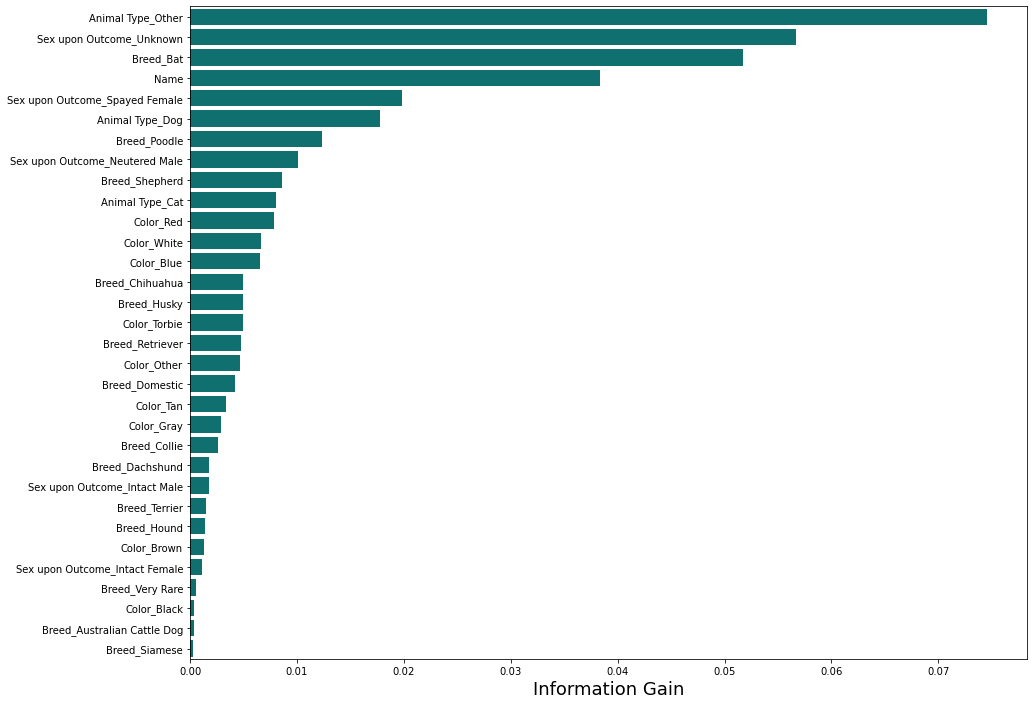

In [53]:
plt.figure(figsize=(15, 12))
f = features_ig[features_ig["I-Gain"] > 0]
sns.barplot(x="I-Gain", y=f.index, data=f, color="teal")
plt.xlabel("Information Gain", fontsize=18)
plt.show()

In [54]:
# Select top 10 features ranked by I-Gain
print("Features selected by filter technique:")
top_10_features_filter = list(features_ig[:10].index)
top_10_features_filter, len(top_10_features_filter)

Features selected by filter technique:


(['Animal Type_Other',
  'Sex upon Outcome_Unknown',
  'Breed_Bat',
  'Name',
  'Sex upon Outcome_Spayed Female',
  'Animal Type_Dog',
  'Breed_Poodle',
  'Sex upon Outcome_Neutered Male',
  'Breed_Shepherd',
  'Animal Type_Cat'],
 10)

### 5. Selection with Wrappers

Wrapper techniques, although more computationally expensive than filters, are good at dealing with issues such as the lack of model bias and feature dependencies. The classifier is inherently part of the selection algorithm.

In [55]:
y_train.value_counts()

0    3471
1     277
Name: Outcome, dtype: int64

- Due to the high target class imbalance, we will use F1 as the scoring metric for the sequential feature selector wrapper technique (that chooses a subset by adding/removing one feature at a time).
- With `k_features` as `"best"` instead of an integer, the feature selector will return the feature subset with the best cross-validation performance.
- A `cv` value of 10 implies 10-fold cross validation, where the score (based on selected metric) is computed 10 consecutive times (with different splits each time). 
- A value of `n_jobs = -1` forces the algorithm to use all available CPUs and generally provides a speed-up. 

In [56]:
# Perform forward/backward sequential search with a given classifier
def sequential_fs(clf: Union[DecisionTreeClassifier, GaussianNB, SVC, KNeighborsClassifier], 
                  forward: bool, 
                  k: Union[int, str] = "best", 
                  scoring: str = "f1", 
                  cv: int = 10,
                  n_jobs: int = -1,
                  figsize: Tuple[int, int] = (12, 6)) -> pd.DataFrame:
    # Apply wrapper with cross-validation and measure execution time
    t1 = time.time()
    sfs = SFS(clf, k_features=k, forward=forward, scoring=scoring, cv=cv, n_jobs=n_jobs)
    sfs = sfs.fit(X_train, y_train, custom_feature_names=X_train.columns)
    t2 = time.time()
    
    dct = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
    mini, maxi = min(dct["avg_score"]), max(dct["avg_score"])

    # Plot
    plot_sfs(sfs.get_metric_dict(), ylabel=scoring, figsize=figsize)
    plt.ylim([mini * 0.9, maxi * 1.1])
    plt.title(f"Sequential {'Forward' if forward else 'Backward'} Selection ({clf})", fontsize=16)
    plt.grid()
    plt.show()
    
    # "Best" feature subset
    subset = dct.loc[dct["avg_score"] == maxi, "feature_names"].sort_index().iloc[0]
    
    # Display results
    print(f"Time taken to fit SFS: {t2 - t1:.3f} seconds")
    print(f"Scoring: {scoring}")
    print(f"Smallest feature subset (size = {len(subset)}) with max. score ({maxi}):")
    pprint(subset)
    
    print("\nTop 5 feature subsets in descending order of average score and ascending order of size:")
    return {
        "sfs": sfs,
        "subset": list(subset),
        "avg_score": maxi,
        "top5": dct.rename_axis("#").sort_values(by=["avg_score", "#"], ascending=[False, True]).head()
    }


# Dictionary to store results for multiple classifiers
sfs = defaultdict(dict)

#### i. Decision Tree Classifier

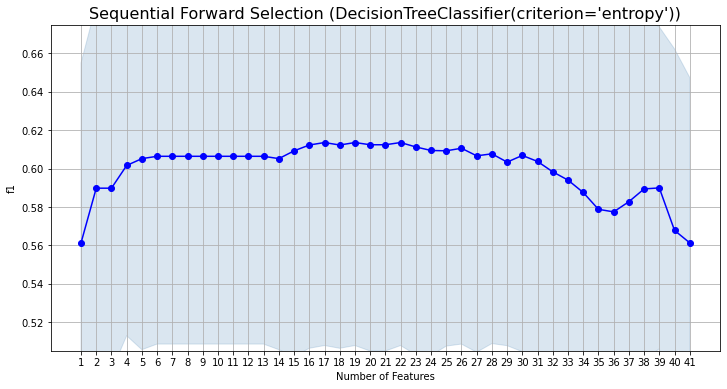

Time taken to fit SFS: 7.536 seconds
Scoring: f1
Smallest feature subset (size = 17) with max. score (0.613577131139243):
('Name',
 'Age in Days upon Outcome',
 'Animal Type_Cat',
 'Animal Type_Dog',
 'Animal Type_Other',
 'Sex upon Outcome_Intact Male',
 'Sex upon Outcome_Unknown',
 'Breed_Australian Cattle Dog',
 'Breed_Beagle',
 'Breed_Boxer',
 'Breed_Chihuahua',
 'Breed_Collie',
 'Breed_Hound',
 'Breed_Pit Bull',
 'Breed_Poodle',
 'Breed_Rare',
 'Color_Orange')

Top 5 feature subsets in descending order of average score and ascending order of size:


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
#,,,,,,,
17,"(0, 1, 2, 3, 4, 6, 9, 10, 12, 13, 14, 15, 18, ...","[0.8163265306122449, 0.7346938775510204, 0.5, ...",0.613577,"(Name, Age in Days upon Outcome, Animal Type_C...",0.078468,0.105651,0.035217
19,"(0, 1, 2, 3, 4, 6, 9, 10, 12, 13, 14, 15, 16, ...","[0.8163265306122449, 0.7346938775510204, 0.5, ...",0.613577,"(Name, Age in Days upon Outcome, Animal Type_C...",0.078468,0.105651,0.035217
22,"(0, 1, 2, 3, 4, 6, 9, 10, 12, 13, 14, 15, 16, ...","[0.8163265306122449, 0.7346938775510204, 0.5, ...",0.613577,"(Name, Age in Days upon Outcome, Animal Type_C...",0.078468,0.105651,0.035217
20,"(0, 1, 2, 3, 4, 6, 9, 10, 12, 13, 14, 15, 16, ...","[0.8163265306122449, 0.7346938775510204, 0.5, ...",0.612423,"(Name, Age in Days upon Outcome, Animal Type_C...",0.079733,0.107354,0.035785
21,"(0, 1, 2, 3, 4, 6, 9, 10, 12, 13, 14, 15, 16, ...","[0.8163265306122449, 0.7346938775510204, 0.5, ...",0.612423,"(Name, Age in Days upon Outcome, Animal Type_C...",0.079733,0.107354,0.035785


In [57]:
dt = DecisionTreeClassifier(criterion="entropy")
clf_name = dt.__class__.__name__
sfs[clf_name]["forward"] = sequential_fs(dt, forward=True)
sfs[clf_name]["forward"]["top5"]

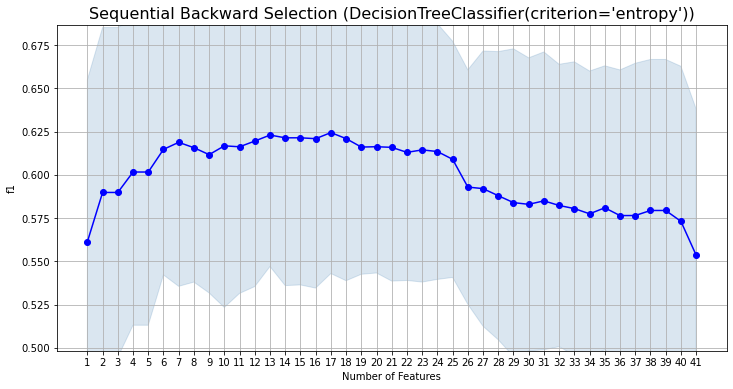

Time taken to fit SFS: 10.343 seconds
Scoring: f1
Smallest feature subset (size = 17) with max. score (0.6244344171822142):
('Name',
 'Age in Days upon Outcome',
 'Animal Type_Other',
 'Sex upon Outcome_Intact Female',
 'Sex upon Outcome_Neutered Male',
 'Sex upon Outcome_Spayed Female',
 'Sex upon Outcome_Unknown',
 'Breed_Boxer',
 'Breed_Chihuahua',
 'Breed_Pit Bull',
 'Breed_Rare',
 'Breed_Very Rare',
 'Color_Blue',
 'Color_Brown',
 'Color_Gray',
 'Color_Orange',
 'Color_Yellow')

Top 5 feature subsets in descending order of average score and ascending order of size:


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
#,,,,,,,
17,"(0, 1, 4, 5, 7, 8, 9, 13, 14, 20, 22, 27, 29, ...","[0.782608695652174, 0.7200000000000001, 0.5531...",0.624434,"(Name, Age in Days upon Outcome, Animal Type_O...",0.060523,0.081489,0.027163
13,"(0, 1, 4, 5, 7, 8, 9, 20, 22, 27, 29, 30, 32)","[0.782608695652174, 0.7083333333333333, 0.5531...",0.623021,"(Name, Age in Days upon Outcome, Animal Type_O...",0.056473,0.076036,0.025345
15,"(0, 1, 4, 5, 7, 8, 9, 13, 20, 22, 27, 29, 30, ...","[0.782608695652174, 0.7200000000000001, 0.5217...",0.621432,"(Name, Age in Days upon Outcome, Animal Type_O...",0.063192,0.085083,0.028361
14,"(0, 1, 4, 5, 7, 8, 9, 20, 22, 27, 29, 30, 31, 32)","[0.782608695652174, 0.7200000000000001, 0.5217...",0.621424,"(Name, Age in Days upon Outcome, Animal Type_O...",0.063477,0.085466,0.028489
18,"(0, 1, 4, 5, 7, 8, 9, 13, 14, 20, 22, 27, 29, ...","[0.782608695652174, 0.7058823529411765, 0.5957...",0.620966,"(Name, Age in Days upon Outcome, Animal Type_O...",0.061047,0.082195,0.027398


In [58]:
sfs[clf_name]["backward"] = sequential_fs(dt, forward=False)
sfs[clf_name]["backward"]["top5"]

#### ii. Naive Bayes Classifier

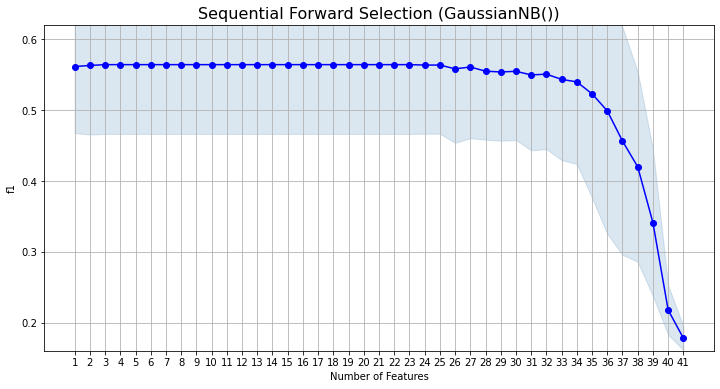

Time taken to fit SFS: 3.619 seconds
Scoring: f1
Smallest feature subset (size = 3) with max. score (0.5640204124324624):
('Animal Type_Other', 'Breed_Bat', 'Color_Red')

Top 5 feature subsets in descending order of average score and ascending order of size:


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
#,,,,,,,
3,"(4, 11, 34)","[0.7999999999999999, 0.6122448979591837, 0.478...",0.56402,"(Animal Type_Other, Breed_Bat, Color_Red)",0.072526,0.09765,0.03255
4,"(0, 4, 11, 34)","[0.7999999999999999, 0.6122448979591837, 0.478...",0.56402,"(Name, Animal Type_Other, Breed_Bat, Color_Red)",0.072526,0.09765,0.03255
5,"(0, 1, 4, 11, 34)","[0.7999999999999999, 0.6122448979591837, 0.478...",0.56402,"(Name, Age in Days upon Outcome, Animal Type_O...",0.072526,0.09765,0.03255
6,"(0, 1, 2, 4, 11, 34)","[0.7999999999999999, 0.6122448979591837, 0.478...",0.56402,"(Name, Age in Days upon Outcome, Animal Type_C...",0.072526,0.09765,0.03255
7,"(0, 1, 2, 3, 4, 11, 34)","[0.7999999999999999, 0.6122448979591837, 0.478...",0.56402,"(Name, Age in Days upon Outcome, Animal Type_C...",0.072526,0.09765,0.03255


In [59]:
gnb = GaussianNB()
clf_name = gnb.__class__.__name__
sfs[clf_name]["forward"] = sequential_fs(gnb, forward=True)
sfs[clf_name]["forward"]["top5"]

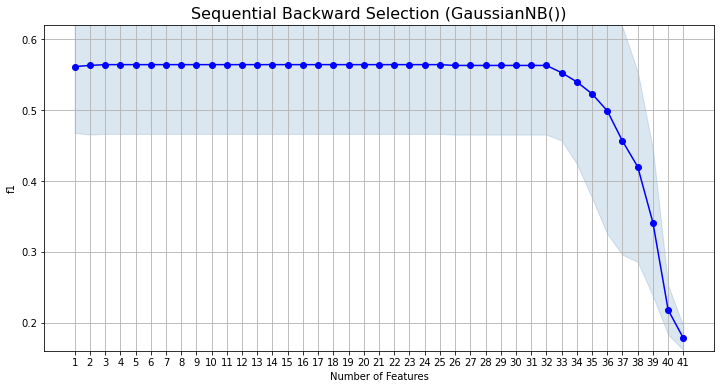

Time taken to fit SFS: 4.164 seconds
Scoring: f1
Smallest feature subset (size = 3) with max. score (0.5640204124324624):
('Animal Type_Other', 'Breed_Bat', 'Color_Red')

Top 5 feature subsets in descending order of average score and ascending order of size:


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
#,,,,,,,
3,"(4, 11, 34)","[0.7999999999999999, 0.6122448979591837, 0.478...",0.56402,"(Animal Type_Other, Breed_Bat, Color_Red)",0.072526,0.09765,0.03255
4,"(0, 4, 11, 34)","[0.7999999999999999, 0.6122448979591837, 0.478...",0.56402,"(Name, Animal Type_Other, Breed_Bat, Color_Red)",0.072526,0.09765,0.03255
5,"(0, 1, 4, 11, 34)","[0.7999999999999999, 0.6122448979591837, 0.478...",0.56402,"(Name, Age in Days upon Outcome, Animal Type_O...",0.072526,0.09765,0.03255
6,"(0, 1, 2, 4, 11, 34)","[0.7999999999999999, 0.6122448979591837, 0.478...",0.56402,"(Name, Age in Days upon Outcome, Animal Type_C...",0.072526,0.09765,0.03255
7,"(0, 1, 2, 3, 4, 11, 34)","[0.7999999999999999, 0.6122448979591837, 0.478...",0.56402,"(Name, Age in Days upon Outcome, Animal Type_C...",0.072526,0.09765,0.03255


In [60]:
sfs[clf_name]["backward"] = sequential_fs(gnb, forward=False)
sfs[clf_name]["backward"]["top5"]

#### iii. SVM (Support Vector Machine) Classifier

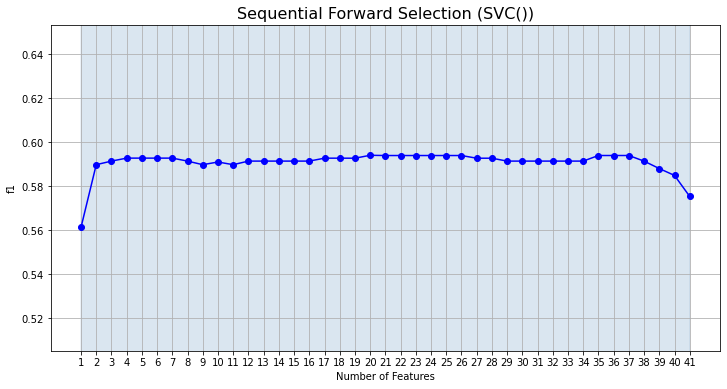

Time taken to fit SFS: 86.304 seconds
Scoring: f1
Smallest feature subset (size = 20) with max. score (0.5940966496414545):
('Name',
 'Age in Days upon Outcome',
 'Animal Type_Cat',
 'Animal Type_Dog',
 'Animal Type_Other',
 'Sex upon Outcome_Intact Female',
 'Sex upon Outcome_Intact Male',
 'Sex upon Outcome_Neutered Male',
 'Sex upon Outcome_Spayed Female',
 'Breed_Australian Cattle Dog',
 'Breed_Bat',
 'Breed_Beagle',
 'Breed_Boxer',
 'Breed_Chihuahua',
 'Breed_Collie',
 'Breed_Domestic',
 'Breed_Husky',
 'Color_Gray',
 'Color_Red',
 'Color_Tricolor')

Top 5 feature subsets in descending order of average score and ascending order of size:


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
#,,,,,,,
20,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[0.8163265306122449, 0.6666666666666667, 0.511...",0.594097,"(Name, Age in Days upon Outcome, Animal Type_C...",0.073856,0.099441,0.033147
35,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[0.8163265306122449, 0.6666666666666667, 0.511...",0.593998,"(Name, Age in Days upon Outcome, Animal Type_C...",0.072797,0.098015,0.032672
36,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[0.8163265306122449, 0.6666666666666667, 0.511...",0.593998,"(Name, Age in Days upon Outcome, Animal Type_C...",0.072797,0.098015,0.032672
37,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[0.8163265306122449, 0.6666666666666667, 0.511...",0.593998,"(Name, Age in Days upon Outcome, Animal Type_C...",0.072797,0.098015,0.032672
21,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[0.8163265306122449, 0.6666666666666667, 0.523...",0.593985,"(Name, Age in Days upon Outcome, Animal Type_C...",0.07278,0.097993,0.032664


In [61]:
svm = SVC()
clf_name = svm.__class__.__name__
sfs[clf_name]["forward"] = sequential_fs(svm, forward=True)
sfs[clf_name]["forward"]["top5"]

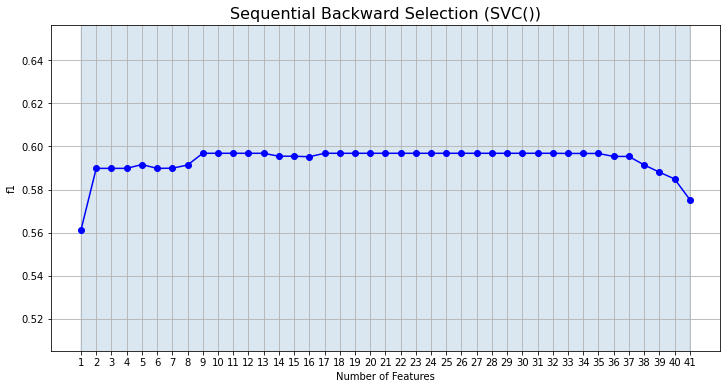

Time taken to fit SFS: 148.685 seconds
Scoring: f1
Smallest feature subset (size = 9) with max. score (0.5968141648660857):
('Name',
 'Age in Days upon Outcome',
 'Animal Type_Other',
 'Sex upon Outcome_Intact Female',
 'Sex upon Outcome_Intact Male',
 'Color_Black',
 'Color_Brown',
 'Color_Gray',
 'Color_Other')

Top 5 feature subsets in descending order of average score and ascending order of size:


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
#,,,,,,,
9,"(0, 1, 4, 5, 6, 28, 30, 31, 33)","[0.8163265306122449, 0.6666666666666667, 0.511...",0.596814,"(Name, Age in Days upon Outcome, Animal Type_O...",0.072972,0.09825,0.03275
10,"(0, 1, 4, 5, 6, 8, 28, 30, 31, 33)","[0.8163265306122449, 0.6666666666666667, 0.511...",0.596814,"(Name, Age in Days upon Outcome, Animal Type_O...",0.072972,0.09825,0.03275
11,"(0, 1, 2, 4, 5, 6, 8, 28, 30, 31, 33)","[0.8163265306122449, 0.6666666666666667, 0.511...",0.596814,"(Name, Age in Days upon Outcome, Animal Type_C...",0.072972,0.09825,0.03275
12,"(0, 1, 2, 4, 5, 6, 8, 10, 28, 30, 31, 33)","[0.8163265306122449, 0.6666666666666667, 0.511...",0.596814,"(Name, Age in Days upon Outcome, Animal Type_C...",0.072972,0.09825,0.03275
13,"(0, 1, 2, 4, 5, 6, 8, 10, 12, 28, 30, 31, 33)","[0.8163265306122449, 0.6666666666666667, 0.511...",0.596814,"(Name, Age in Days upon Outcome, Animal Type_C...",0.072972,0.09825,0.03275


In [62]:
sfs[clf_name]["backward"] = sequential_fs(svm, forward=False)
sfs[clf_name]["backward"]["top5"]

#### iv. k-NN (K-Nearest Neighbours) Classifier

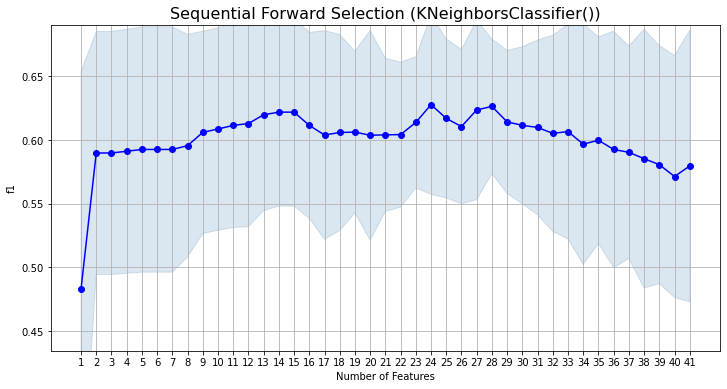

Time taken to fit SFS: 32.430 seconds
Scoring: f1
Smallest feature subset (size = 24) with max. score (0.6277571642694647):
('Name',
 'Age in Days upon Outcome',
 'Animal Type_Cat',
 'Animal Type_Other',
 'Sex upon Outcome_Neutered Male',
 'Sex upon Outcome_Spayed Female',
 'Breed_Beagle',
 'Breed_Boxer',
 'Breed_Chihuahua',
 'Breed_Collie',
 'Breed_Domestic',
 'Breed_Hound',
 'Breed_Husky',
 'Breed_Poodle',
 'Breed_Rare',
 'Breed_Retriever',
 'Breed_Shepherd',
 'Breed_Terrier',
 'Breed_Very Rare',
 'Color_Gray',
 'Color_Other',
 'Color_Red',
 'Color_Tricolor',
 'Color_White')

Top 5 feature subsets in descending order of average score and ascending order of size:


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
#,,,,,,,
24,"(0, 1, 2, 4, 7, 8, 12, 13, 14, 15, 17, 18, 19,...","[0.7659574468085106, 0.6530612244897959, 0.622...",0.627757,"(Name, Age in Days upon Outcome, Animal Type_C...",0.052299,0.070416,0.023472
28,"(0, 1, 2, 4, 7, 8, 12, 13, 14, 15, 16, 17, 18,...","[0.7346938775510203, 0.6530612244897959, 0.622...",0.626364,"(Name, Age in Days upon Outcome, Animal Type_C...",0.039282,0.052889,0.01763
27,"(0, 1, 2, 4, 7, 8, 12, 13, 14, 15, 16, 17, 18,...","[0.7659574468085106, 0.6956521739130435, 0.604...",0.623596,"(Name, Age in Days upon Outcome, Animal Type_C...",0.052324,0.07045,0.023483
14,"(0, 1, 2, 4, 7, 8, 18, 19, 23, 24, 27, 33, 38,...","[0.7659574468085106, 0.6808510638297872, 0.565...",0.62187,"(Name, Age in Days upon Outcome, Animal Type_C...",0.054764,0.073735,0.024578
15,"(0, 1, 2, 4, 7, 8, 12, 18, 19, 23, 24, 27, 33,...","[0.7659574468085106, 0.6808510638297872, 0.565...",0.62187,"(Name, Age in Days upon Outcome, Animal Type_C...",0.054764,0.073735,0.024578


In [63]:
knn = KNeighborsClassifier() 
clf_name = knn.__class__.__name__
sfs[clf_name]["forward"] = sequential_fs(knn, forward=True)
sfs[clf_name]["forward"]["top5"]

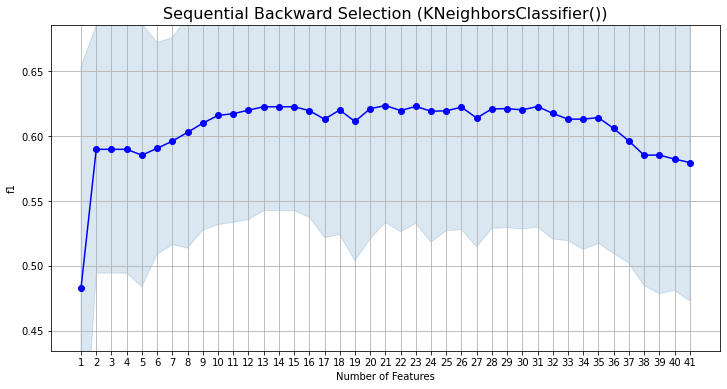

Time taken to fit SFS: 46.430 seconds
Scoring: f1
Smallest feature subset (size = 21) with max. score (0.6235119541220221):
('Name',
 'Age in Days upon Outcome',
 'Animal Type_Other',
 'Sex upon Outcome_Intact Female',
 'Sex upon Outcome_Neutered Male',
 'Sex upon Outcome_Spayed Female',
 'Sex upon Outcome_Unknown',
 'Breed_Australian Cattle Dog',
 'Breed_Bat',
 'Breed_Beagle',
 'Breed_Chihuahua',
 'Breed_Dachshund',
 'Breed_Domestic',
 'Breed_Husky',
 'Breed_Pit Bull',
 'Breed_Retriever',
 'Breed_Siamese',
 'Color_Brown',
 'Color_Gray',
 'Color_Orange',
 'Color_Tricolor')

Top 5 feature subsets in descending order of average score and ascending order of size:


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
#,,,,,,,
21,"(0, 1, 4, 5, 7, 8, 9, 10, 11, 12, 14, 16, 17, ...","[0.7999999999999999, 0.7450980392156864, 0.523...",0.623512,"(Name, Age in Days upon Outcome, Animal Type_O...",0.066884,0.090054,0.030018
23,"(0, 1, 4, 5, 7, 8, 9, 10, 11, 12, 14, 16, 17, ...","[0.7843137254901961, 0.76, 0.5238095238095237,...",0.622849,"(Name, Age in Days upon Outcome, Animal Type_O...",0.067032,0.090253,0.030084
31,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.7999999999999999, 0.6938775510204083, 0.487...",0.622786,"(Name, Age in Days upon Outcome, Animal Type_C...",0.069049,0.092969,0.03099
13,"(0, 1, 4, 7, 8, 9, 11, 14, 17, 20, 23, 25, 32)","[0.7843137254901961, 0.6938775510204083, 0.536...",0.6226,"(Name, Age in Days upon Outcome, Animal Type_O...",0.059476,0.080079,0.026693
14,"(0, 1, 4, 7, 8, 9, 11, 14, 16, 17, 20, 23, 25,...","[0.7843137254901961, 0.6938775510204083, 0.536...",0.6226,"(Name, Age in Days upon Outcome, Animal Type_O...",0.059476,0.080079,0.026693


In [64]:
sfs[clf_name]["backward"] = sequential_fs(knn, forward=False)
sfs[clf_name]["backward"]["top5"]

### 6. Insights

Optimal feature subset using filter technique based on mutual information criterion:

In [65]:
filter_subset = top_10_features_filter
filter_subset

['Animal Type_Other',
 'Sex upon Outcome_Unknown',
 'Breed_Bat',
 'Name',
 'Sex upon Outcome_Spayed Female',
 'Animal Type_Dog',
 'Breed_Poodle',
 'Sex upon Outcome_Neutered Male',
 'Breed_Shepherd',
 'Animal Type_Cat']

For the sequential search wrapper technique, we can select the better of forward and backward SFS average scores for each of the 4 classifiers.

- It is possible that forward and backward SFS sometimes find the same feature subset.
- Although not always the case, backward SFS (more computationally expensive) yields better results than the forward counterpart.

In [66]:
wrapper_subsets = {}

for clf_name in sfs:
    print(f"{clf_name}\n")
    f_score = sfs[clf_name]["forward"]["avg_score"]
    b_score = sfs[clf_name]["backward"]["avg_score"]
    print(f"Forward SFS avg. score: {f_score}")
    print(f"Backward SFS avg. score: {b_score}")
    
    better = "forward" if f_score >= b_score else "backward"
    wrapper_subsets[clf_name] = sfs[clf_name][better]["subset"]
    print(f"Better: {better}\n-----\n")

DecisionTreeClassifier

Forward SFS avg. score: 0.613577131139243
Backward SFS avg. score: 0.6244344171822142
Better: backward
-----

GaussianNB

Forward SFS avg. score: 0.5640204124324624
Backward SFS avg. score: 0.5640204124324624
Better: forward
-----

SVC

Forward SFS avg. score: 0.5940966496414545
Backward SFS avg. score: 0.5968141648660857
Better: backward
-----

KNeighborsClassifier

Forward SFS avg. score: 0.6277571642694647
Backward SFS avg. score: 0.6235119541220221
Better: forward
-----



- As expected, feature selection with filters is much faster than wrappers.
- On average, sequential search (wrapper) using SVM takes the longest time of all the classifiers.
- Decision Tree and k-NN classifiers yield very similar average scores.

In [67]:
pprint(wrapper_subsets)

{'DecisionTreeClassifier': ['Name',
                            'Age in Days upon Outcome',
                            'Animal Type_Other',
                            'Sex upon Outcome_Intact Female',
                            'Sex upon Outcome_Neutered Male',
                            'Sex upon Outcome_Spayed Female',
                            'Sex upon Outcome_Unknown',
                            'Breed_Boxer',
                            'Breed_Chihuahua',
                            'Breed_Pit Bull',
                            'Breed_Rare',
                            'Breed_Very Rare',
                            'Color_Blue',
                            'Color_Brown',
                            'Color_Gray',
                            'Color_Orange',
                            'Color_Yellow'],
 'GaussianNB': ['Animal Type_Other', 'Breed_Bat', 'Color_Red'],
 'KNeighborsClassifier': ['Name',
                          'Age in Days upon Outcome',
                        

We can count the frequency of occurrence of different features in the subsets returned by filter and wrapper techniques:

In [68]:
freq = Counter(list(itertools.chain(filter_subset, *wrapper_subsets.values())))
freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
freq[:20]

[('Animal Type_Other', 5),
 ('Name', 4),
 ('Sex upon Outcome_Spayed Female', 3),
 ('Sex upon Outcome_Neutered Male', 3),
 ('Age in Days upon Outcome', 3),
 ('Color_Gray', 3),
 ('Sex upon Outcome_Unknown', 2),
 ('Breed_Bat', 2),
 ('Breed_Poodle', 2),
 ('Breed_Shepherd', 2),
 ('Animal Type_Cat', 2),
 ('Sex upon Outcome_Intact Female', 2),
 ('Breed_Boxer', 2),
 ('Breed_Chihuahua', 2),
 ('Breed_Rare', 2),
 ('Breed_Very Rare', 2),
 ('Color_Brown', 2),
 ('Color_Red', 2),
 ('Color_Other', 2),
 ('Animal Type_Dog', 1)]

- Based on the mutual information (entropy based) criterion, the filter technique suggests that `'Animal Type_Other', 'Sex upon Outcome_Unknown', 'Breed_Bat', 'Name'` are some of the most discriminatory features. These features also appear frequently in some wrapper technique subsets.
- We can compute the percentage of negative outcomes for different `Animal Type`, `Sex upon Outcome` and `Breed` categories and look for explanations for the above observations.

In [69]:
def neg_outcome_perc(feature: str) -> None:
    seen = {}
    print(f"Percentage negative outcome (1) by {feature}:\n")
    for cat in [col for col in df.columns if f"{feature}_" in col]:
        counts = y_train[X_train[X_train[cat] == 1].index].value_counts()
        num = counts.loc[1] if 1 in counts.index else 0
        seen[cat] = 100 * num/(sum(counts))
    for k, v in sorted(seen.items(), key=lambda x: x[1]):
        print(f"{v:.2f}%\t| {k}")
    
        
neg_outcome_perc("Animal Type")

Percentage negative outcome (1) by Animal Type:

3.40%	| Animal Type_Dog
5.19%	| Animal Type_Cat
70.81%	| Animal Type_Other


- As expected, dogs and cats are far more common as pets (likely to be adopted/returned to owner), and hence have a negligible chance of negative outcome (class = 1) compared to other types of animals.

In [70]:
neg_outcome_perc("Breed")

Percentage negative outcome (1) by Breed:

0.00%	| Breed_Dachshund
0.00%	| Breed_Husky
1.45%	| Breed_Retriever
1.87%	| Breed_Chihuahua
2.04%	| Breed_Collie
2.33%	| Breed_Beagle
2.34%	| Breed_Terrier
2.70%	| Breed_Hound
3.85%	| Breed_Boxer
5.00%	| Breed_Poodle
5.13%	| Breed_Siamese
5.15%	| Breed_Domestic
5.32%	| Breed_Shepherd
6.85%	| Breed_Australian Cattle Dog
7.88%	| Breed_Pit Bull
11.68%	| Breed_Very Rare
11.89%	| Breed_Rare
100.00%	| Breed_Bat


- In the given dataset, bats are noted as `Animal Type_Other` with `Breed_Bat`. 100% of bats at the animal shelter are shown to face a negative outcome.
- In Texas, bats, by law, are defined as high-risk animals for rabies and touching a bat for any reason is not allowed (Animal Control must be called if a bat is found).
- Furthermore, domestic animals exposed to a rabid bat require a series of rabies vaccination boosters and a quarantine period, and in some instances euthanasia if necessary.

In [71]:
neg_outcome_perc("Sex upon Outcome")

Percentage negative outcome (1) by Sex upon Outcome:

1.62%	| Sex upon Outcome_Spayed Female
2.88%	| Sex upon Outcome_Neutered Male
8.18%	| Sex upon Outcome_Intact Female
9.32%	| Sex upon Outcome_Intact Male
50.00%	| Sex upon Outcome_Unknown


- Animals with a recorded negative outcome are far more likely to have sex marked as unknown, and the importance of this feature is highlighted by feature selection techniques.

In [72]:
# Name is present
y_train[X_train[X_train["Name"] == 1].index].value_counts()

0    2536
1      62
Name: Outcome, dtype: int64

In [73]:
# Name is absent
y_train[X_train[X_train["Name"] == 0].index].value_counts()

0    935
1    215
Name: Outcome, dtype: int64

- With regards to `Name`, it appears that an animal with a name is far more likely to have a positive outcome (2536:62) than without (935:215). This is plausible, since a named animal has a high chance of being a pet which can be returned to its owner.
- Actions to improve the adoption/return rate of animals:
  - Consider putting up fewer animals of similar kind up for adoption at any given time. When given too many choices, it makes it difficult for adopters to make a decision.
  - Groom the animals to make them more appealing, since appearance plays an important role in influencing a positive outcome.

## 1C: Modelling and Evaluation

With the discriminating features selected, we can proceed with model building and evaluation. The cleaned dataset had already been split into training (75%) and testing (25%) sets before the feature selection process.

In [74]:
y_train.value_counts()

0    3471
1     277
Name: Outcome, dtype: int64

- The training set target class only has 277 instances of negative outcome (minority class = 1) and 3471 positives (majority class = 0).
- For such kinds of data, it doesn't make sense to rely on classification accuracy/error as a metric, as the model will be biased towards the majority class.
- A *confusion matrix* summarises every classifier's performance by revealing the True Positives, True Negatives, False Positives and False Negatives. Some measures based on these values include: precision, recall (sensitivity), specificity (True Negative rate), etc.
- As described earlier, the primary metric to be used for scoring here is **`f1`** due to the **high imbalance in the target class**.
- The F1 measure is the harmonic mean of precision and recall. In the given scenario, the **cost of False Positive** (predicted class = 1, actual class = 0) is greater than that of False Negative (predicted = 0, actual = 1), since it is not desirable to predict a bad outcome (death) for an animal that could be adopted/returned to owner.
- When working on problems with imbalanced datasets where detecting positives is more important than detecting negatives, F1 is more suitable than other balanced evaluation measures like balanced accuracy.

Below, we store the different training and test sets for the 4 classifiers based on the highest scoring feature subsets selected by the wrapper technique (sequential search). Only the appropriate feature subsets will be used for different classifiers during hyperparameter optimisation and model evaluation.

In [75]:
X_train_sub, X_test_sub = {}, {}
for clf in [dt, gnb, svm, knn]:
    clf_name = clf.__class__.__name__
    X_train_sub[clf_name] = X_train[wrapper_subsets[clf_name]]
    X_test_sub[clf_name] = X_test[wrapper_subsets[clf_name]]

### 1. Classifier/hyperparameter tuning

The "best" arguments (called hyperparameters) used when training classifiers can be found using a systematic trial and error approach. All searches use a 10-fold **cross-validation** where in each of 10 experiments, 9 "folds" are used for training and 1 for testing. This is preferable to a naive hold-out strategy as it increases the generalisation capabilities of a model by reducing the chances of overfitting.

During the entire process of tuning hyperparameters, no access to the testing data set is granted. Model parameters are optimised solely using the training set (the split was done after encoding categorical features and before applying filter/wrapper feature selection).

#### i. Decision Tree

- `max_depth` refers to the maximum depth of the tree.
- `min_samples_leaf`  is minimum number of samples required to be at a leaf node.
- `GridSearchCV` is used here to optimise the Decision Tree hyperparameters using a stratified (by default) 10-fold cross-validated grid-search over a parameter grid.

In [76]:
param_grid = {
    "max_depth": [None, 2, 5, 7],
    "min_samples_leaf": [1, 2, 3, 5, 10]
}
clf_name = dt.__class__.__name__
dt_grid = GridSearchCV(dt, param_grid, scoring="f1", cv=10)
dt_grid.fit(X_train_sub[clf_name], y_train)
dt_best = dt_grid.best_estimator_

print(f"Best: {dt_best}")
print(f"Average F1: {dt_grid.best_score_:.3f}")

Best: DecisionTreeClassifier(criterion='entropy')
Average F1: 0.615


#### ii. Naive Bayes

3 different Naive Bayes algorithms can be tried:
- Gaussian: standard Naive Bayes where the likelihood of the features is assumed to be Gaussian.
- Bernoulli: assumes that the data that is distributed according to multivariate Bernoulli distributions.
- Multinomial: naive Bayes algorithm for multinomially distributed data.

In [77]:
cv_strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [78]:
nb_best, max_score = None, 0
clf_name = gnb.__class__.__name__
for nb in [GaussianNB(), BernoulliNB(), MultinomialNB()]:
    scores = cross_val_score(nb, X_train_sub[clf_name], y_train, cv=cv_strat, scoring="f1", n_jobs=-1)
    mean = scores.mean()
    if mean > max_score:
        max_score = mean
        nb_best = nb
    print(f"{nb}\n{cv_strat}\nAverage F1: {mean:.3f} +/- {scores.std():.3f}\n-----")
print(f"Best: {nb_best}")

GaussianNB()
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.564 +/- 0.095
-----
BernoulliNB()
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.564 +/- 0.095
-----
MultinomialNB()
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.414 +/- 0.061
-----
Best: GaussianNB()


#### iii. SVM

We can experiment with different types of kernel functions which are used to transform the data without actually applying them ("kernel trick"):
- `rbf`: Radial Basis Function
- `linear`: `x.x'`.
- `sigmoid`: `tanh(1 + x.x')`
- `poly`: polynomial `(1 + x.x')^t`

In [79]:
svm_best, max_score = None, 0
clf_name = svm.__class__.__name__
for kernel in ["rbf", "linear", "sigmoid", "poly"]:
    clf = SVC(kernel=kernel)
    scores = cross_val_score(clf, X_train_sub[clf_name], y_train, cv=cv_strat, scoring="f1", n_jobs=-1)
    mean = scores.mean()
    if mean > max_score:
        max_score = mean
        svm_best = clf
    print(f"{clf}\n{cv_strat}\nAverage F1: {mean:.3f} +/- {scores.std():.3f}\n-----")
print(f"Best: {svm_best}")

SVC()
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.582 +/- 0.086
-----
SVC(kernel='linear')
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.559 +/- 0.090
-----
SVC(kernel='sigmoid')
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.319 +/- 0.127
-----
SVC(kernel='poly')
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.588 +/- 0.102
-----
Best: SVC(kernel='poly')


#### iv. k-NN

A number of different nearest neighbour values can be tried:

In [80]:
knn_best, max_score = None, 0
clf_name = knn.__class__.__name__
for n in [2, 5, 10, 12, 15]:
    clf = KNeighborsClassifier(n_neighbors=n)
    ts = cross_val_score(clf, X_train_sub[clf_name], y_train, cv=cv_strat, scoring="f1", n_jobs=-1)
    mean = ts.mean()
    if mean > max_score:
        max_score = mean
        knn_best = clf
    print(f"{clf}\n{cv_strat}\nAverage F1: {mean:.3f} +/- {ts.std():.3f}\n-----")
print(f"Best: {knn_best}")    

KNeighborsClassifier(n_neighbors=2)
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.574 +/- 0.095
-----
KNeighborsClassifier()
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.596 +/- 0.096
-----
KNeighborsClassifier(n_neighbors=10)
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.578 +/- 0.098
-----
KNeighborsClassifier(n_neighbors=12)
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.578 +/- 0.103
-----
KNeighborsClassifier(n_neighbors=15)
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
Average F1: 0.597 +/- 0.094
-----
Best: KNeighborsClassifier(n_neighbors=15)


### 2. Evaluation of best classifiers

Based on the parameter setting optimisation above, the best classifiers can now be evaluated.

In [81]:
best_clfs = [dt_best, nb_best, svm_best, knn_best]
best_clfs

[DecisionTreeClassifier(criterion='entropy'),
 GaussianNB(),
 SVC(kernel='poly'),
 KNeighborsClassifier(n_neighbors=15)]

First, we can plot confusion matrices for each of the classifiers for preliminary evaluation, finally using the test data set for the first time to check the performance on unseen data.

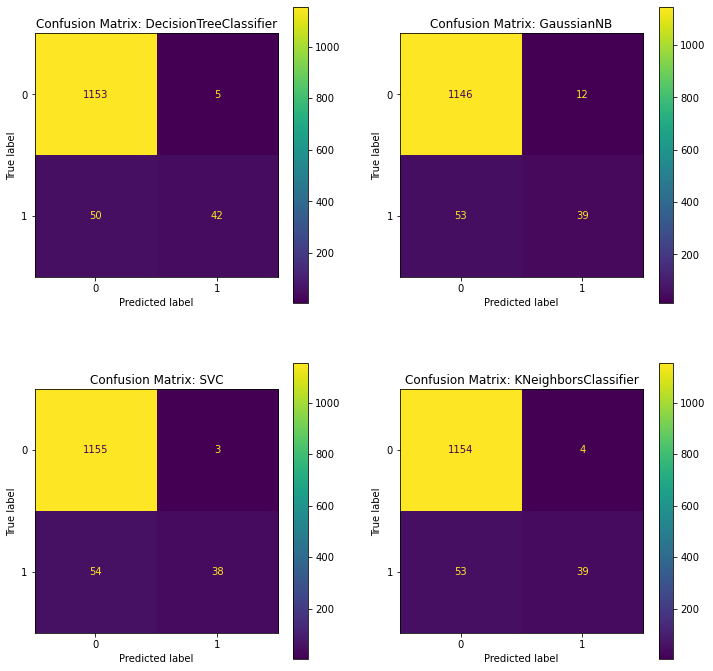

In [82]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
i, j = 0, 0
for clf in best_clfs:
    clf_name = clf.__class__.__name__
    clf.fit(X_train_sub[clf_name], y_train)
    disp = ConfusionMatrixDisplay.from_estimator(clf, X_test_sub[clf_name], y_test, ax=ax[i][j])
    disp.ax_.set_title(f"Confusion Matrix: {clf_name}")    
    j += 1
    if j == 2:
        i += 1
        j = 0

The `DecisionTreeClassifier` has the highest number of True Positives (42) of all 4 models.

Next, we can perform 10-fold stratified cross-validation for a more robust evaluation. As mentioned earlier, this has the following advantages:
- Stratification is the process of rearranging the data so as to ensure that each fold is a good representative of the whole.
- Cross-validation can flag problems such as selection bias and reduce overfitting chances.

In [83]:
for clf in best_clfs:
    clf_name = clf.__class__.__name__
    ts = cross_val_score(clf, X[wrapper_subsets[clf_name]], y, cv=cv_strat, n_jobs=-1, scoring="f1")
    print(f"{clf}\nAverage F1: {ts.mean():.3f} +/- {ts.std():.3f}\n-----")

DecisionTreeClassifier(criterion='entropy')
Average F1: 0.617 +/- 0.057
-----
GaussianNB()
Average F1: 0.560 +/- 0.081
-----
SVC(kernel='poly')
Average F1: 0.587 +/- 0.062
-----
KNeighborsClassifier(n_neighbors=15)
Average F1: 0.607 +/- 0.072
-----


As shown above, the **Decision Tree** classifier (with default hyperparameter values for `max_depth` and `min_samples_leaf`) using the feature subset obtained using sequential search (wrapper) yields the best result (based on average F1 score).

## 1D: ROC Analysis

An ROC (Receiver Operating Characteristic) curve plots the **sensitivity versus specificity** for a binary classifier system as its discrimination threshold is varied. First, a dummy classifier must be defined, which acts as a baseline and always predicts the majority class without learning anything from the data.

In [84]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print(dummy_clf)
print(f"Accuracy: {dummy_clf.score(X_test, y_test):.3f}")
print(f"F1: {f1_score(y_test, dummy_clf.predict(X_test)):.3f}")

DummyClassifier(strategy='most_frequent')
Accuracy: 0.926
F1: 0.000


The high accuracy and 0 F1 score reflects the class imbalance issue in the dataset. Next, ROC curves can be plotted for target class = 1 with each of the chosen classifiers. The area under the curve (AUROC/AUC) is used to compare the models, since  in general, higher the AUC, higher is the model's capability of distinguishing between the 1 and 0 target classes.

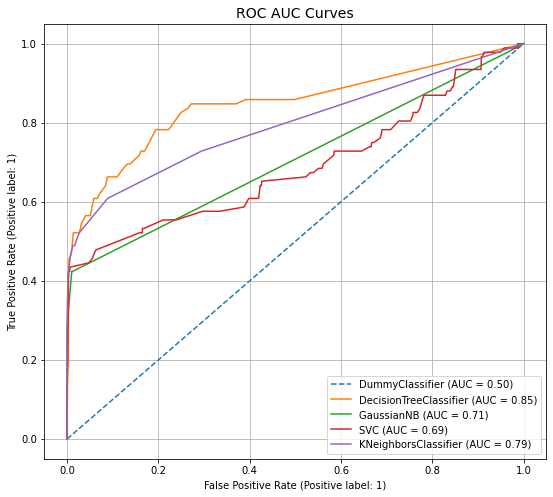

In [85]:
disp = RocCurveDisplay.from_estimator(dummy_clf, X_test, y_test, pos_label=1, linestyle="--")
for clf in [dt_best, nb_best, svm_best, knn_best]:
    clf_name = clf.__class__.__name__
    disp = RocCurveDisplay.from_estimator(clf, X_test_sub[clf_name], y_test, pos_label=1, ax=disp.ax_)

disp.ax_.grid()
disp.figure_.set_size_inches(9, 8)
disp.ax_.set_title("ROC AUC Curves", fontsize=14);

From the ROC curves above, we learn that the `DecisionTreeClassifier` using entropy as criterion has the maximum area under the curve (`AUC`), implying the greatest ability to separate the target classes. The performance is satisfactory, as a score of 0.85 is quite close to perfect score of 1. It is considerably better than the dummy classifier that always predicts the majority class.

## 1E: Discussion of Results

The evaluation in both part C and D suggest that the `DecisionTreeClassifier(criterion='entropy')` is best suited for the given classification task on animal shelter data.

In [86]:
best_clf = dt_best
clf_name = best_clf.__class__.__name__

In [87]:
def evaluate(classifier, X: pd.DataFrame, y: pd.Series) -> None:
    res = cross_validate(classifier, X, y, cv=cv_strat, scoring=["f1", "roc_auc"], n_jobs=-1)
    f1, auc = res["test_f1"], res["test_roc_auc"]
    print(f"{classifier}\n{cv_strat}\n")
    print(f"Average F1: {f1.mean():.3f} +/- {f1.std():.3f}")
    print(f"Average ROC AUC: {auc.mean():.3f} +/- {auc.std():.3f}")

We can prove that the performance of the classifier increases after feature selection:

In [88]:
# original dataset
evaluate(best_clf, X, y)

DecisionTreeClassifier(criterion='entropy')
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

Average F1: 0.571 +/- 0.056
Average ROC AUC: 0.774 +/- 0.034


In [89]:
# utilise feature subset selection
evaluate(best_clf, X[wrapper_subsets[clf_name]], y)

DecisionTreeClassifier(criterion='entropy')
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

Average F1: 0.618 +/- 0.057
Average ROC AUC: 0.806 +/- 0.045


Using a familiar stratified 10-fold cross-validation strategy, both the average F1 and ROC AUC scores for the chosen classifier are higher when using the feature subset selected using sequential search (wrapper technique), compared to original dataset with all features.

- The relative performance of the 4 different classifiers is more or less in line with expectations. Decision trees often perform well on imbalanced datasets as they work by learning a hierarchy of questions which forces both classes to be addressed.
- Looking at the average F1 score in part C, the Naive Bayes classifier performed quite poorly. Although Naive Bayes can usually overcome this problem in real-world scenarios, the decreased scores are possibly a result of the basic underlying assumption of conditional independence failing for the given dataset.

### Ensemble methods

Additionally, we can take a look at ensemble methods for classification, which combine the predictions from multiple base classifiers to improve generalisability and robustness. There are two main types of ensembles: bagging (e.g. Random Forest) and boosting (e.g. AdaBoost, Gradient Tree Boosting).

The three ensemble methods mentioned below all use a Decision Tree as the base estimator.

- `RandomForestClassifier`: "fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting".
- `AdaBoostClassifier`: "fits a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases".
- `GradientBoostingClassifier`: "additive model in a forward stage-wise fashion; it allows for the optimisation of arbitrary differentiable loss functions".

In [90]:
rf = RandomForestClassifier(criterion="entropy")
ab = AdaBoostClassifier(n_estimators=100)
gb = GradientBoostingClassifier()

for clf in [rf, ab, gb]:
    evaluate(clf, X, y)
    print("\n-----\n")

RandomForestClassifier(criterion='entropy')
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

Average F1: 0.580 +/- 0.061
Average ROC AUC: 0.843 +/- 0.039

-----

AdaBoostClassifier(n_estimators=100)
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

Average F1: 0.595 +/- 0.056
Average ROC AUC: 0.875 +/- 0.037

-----

GradientBoostingClassifier()
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

Average F1: 0.601 +/- 0.055
Average ROC AUC: 0.884 +/- 0.032

-----



As shown above, the ROC AUC scores for the ensemble methods are higher than those obtained from simple estimators such as Decisiont Trees, Naive Bayes, SVM and k-NN explored earlier.

## 2: Machine Learning Concepts

a) Consider the nightmare situation in which you struggled hard to obtain a very high accuracy (>95%) on your training data for a binary classification task, but when your client ran it on their test data, the accuracy was very low (<50%). This is despite the fact that your dataset is reasonably balanced (majority class < 65%) and you are using a fairly complex learning algorithms with many parameters to fit your dataset. How do you explain this situation? What are the possible causes for this? How can you improve the testing accuracy in this situation? What precautions should you take in your evaluation procedure to avoid this situation?

**Ans.**

- By definition, this is a case of **overfitting**, as the classification model performs very well on training data but fails to impress on unseen testing data.
- Possible reasons:
  - Data cleaning and feature subset selection was not performed to an adequate degree, and the classifier learned excessive noise in the dataset, thus reducing generalisation accuracy of the model. 
  - It might even be the case that there were more features than observations in the data, and/or the size of the training data was not sufficiently large, especially relative to the number of predictors.
  - The selected classification model has high variance. It is important to consider the bias-variance trade-off when selecting an appropriate classifier.
  - A simple hold-out strategy was used to split the training and testing data while training the model, which possibly led to an unfortunate split, due to which training and testing data were inherently different.
- Improving testing accuracy and taking precautions during evaluation:
  - Use a cross-validation strategy (e.g. K-fold) instead of simple train-test splits.
  - Consider using ensemble classification techniques which reduce the chances of overfitting by combining a large number of base models.
  - Consider the costs of False Positive and False Negative errors and try other appropriate metrics for evaluation, such as precision, recall, F1 score, ROC AUC, and so on, depending on type of data and the goal of classification.

b) What is the kernel trick in SVM? What is the mathematical reasoning that makes it work? Why is the kernel trick important? Give some examples of the kernels together with the situation when you should use it.

**Ans.**

- The basic Support Vector Machine (SVM) algorithm is a convex optimisation problem which aims to maximise the margin of a line that perfectly separates two classes in a binary classification problem.
- By applying a transformation to input data, an SVM classifier is able to map the points to a higher dimension.
- A decision boundary to separate the classes can then be found (hyperplane in the higher dimensional space). This, however, is not the kernel trick.
- The problem arises when there are a large number of features in our data, which will drastically increase the computational time/cost to apply the kernel transformation.
- The **kernel trick** is that kernel functions have a special mathematical property that a function can take as input the original feature vectors and return the dot product of feature vectors in the higher dimensional space.

$$Kernel \; K(x, x') = \phi(x) . \phi(x')$$

- If the dot products are known, it is no longer necessary to actually apply the computationally intensive transformations $\phi(x)$ to the higher dimension!
- The trick is important because in real-world scenarios, it is nearly impossible to find linearly separable classes in a classification task. Kernel SVM is able to solve a variety of complex classification tasks where the classes are far from linearly separable, by looking for a maximal margin hyperplane in higher dimensions.
- Examples of kernels:

| Name | Function | Use Case |
| --- | --- | --- |
| Linear | `x.x'` | Data is linearly separable, especially with a large number of features (e.g. text classification) | 
Polynomial | `(1 + x.x')^t`  | Polynomial model with boundary of defined but arbitrary order |
| RBF (Radial Basis Function) - default in `scikit-learn` | $e^{- \gamma ||x - x'||^2}$ | General purpose |
| Sigmoid | `tanh (1 + x.x')` | Proxy for neural networks | 


- Note:
  - On trying out different kernels (`rbf, poly, linear, sigmoid` on the Labeled Faces in the Wild (LFW) people dataset (`fetch_lfw_people() in sklearn.datasets`), it turns out that `rbf` is the best option. RBF works well in practice and it is relatively easy to tune.
  
  ```
  param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 
              'kernel': ['rbf', 'poly', 'linear', 'sigmoid']
             }
  clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)
  ```


c) What is the curse of dimensionality? Give a mathematical intuition as to why a k-nearest neighbour classifier may struggle on a very high-dimensional data. Give examples of various situations in which you would want to reduce the number of features you consider for classification.

**Ans.**

- The **curse of dimensionality** is the argument against the false intuition that performance of machine learning algorithms keeps increasing with the number of predictor features available.
- In the extreme case where there are more features (columns) than observations (rows), the model will be prone to severe overfitting and will not generalise well for unseen data.
- After a certain point, increasing the number of features actually affects the model significantly, as a lot of noise in the dataset is being learned instead of the core/important features.
- K-nearest neighbour classifiers perform well with a small number of features. However, when the feature set size increases beyond a certain threshold, the volume of input space increases at an exponential rate (considering each feature to be a dimension in an N-dimensional input space). As k-NN is dependent on computing the distances between points in the feature space, these distances keep increasing in higher dimensions, consequently reducing the performance of a k-NN classifier.
- There are a number of scenarios where dimension/feature reduction is desirable:
  - Primary reason: the performance of machine learning algorithms often degrades with high dimensionality, apart from the expected increase in computational time.
  - A model with a limited number of features is easier to explain to clients, as opposed to a "black box" with a large number of features which cannot be interpreted properly.
  - Domain-specific costs: when there is a significant financial cost associated with data generation/collection, we cannot afford to run a large number of experiments, and cost-benefit analysis must be performed to optimise the number of features required to build a well-performing classifier subject to budget constraints.

d) You are working on a classification task to separate fraudulent transactions from the normal financial transactions. What evaluation measure(s) will you use for this application and why? What measure will you not use for this application and why?

**Ans.**

- When working on fraud detection tasks, it is important note the inherent **class imbalance** present in the data: the vast majority of transactions are legitimate/normal, and very few are actually fraudulent.
- Due to this, a dummy classifier which always predicts the majority class may end up being over 99% accurate. This suggests that *accuracy* (or even the complementary metric: *classification error*) is not a good evaluation metric for such cases.
- Instead, we should plot a *Confusion Matrix* which shows the following: TP (True Positive), FN (False Negative), TN (True Negative) and FN (False Negative), and consider alternative metrics like:
  - Precision: TP / (TP+FP)
  - Recall (Sensitivity): TP / (TP+FN)
  - F1 score: 2 * Precision * Recall / (Precision + Recall)
- When trying to separate a fraudulent transaction (class = 1) from a normal one (class = 0), the cost of False Negative (wrongly predict a fraudulent transaction to be genuine) is far greater than raising false alarms with False Positive errors. Hence, *recall* is the primary measure that we should consider for the given classification task.
- Another interesting metric is the ROC Curve and AUC (area under the ROC curve) that plots the TP rate against the FP rate and is a rank based metric, but can be optimistic under a severe class imbalance.